# How To Stratify Data in Machine Learning Projects to Significantly Improve Model Performance

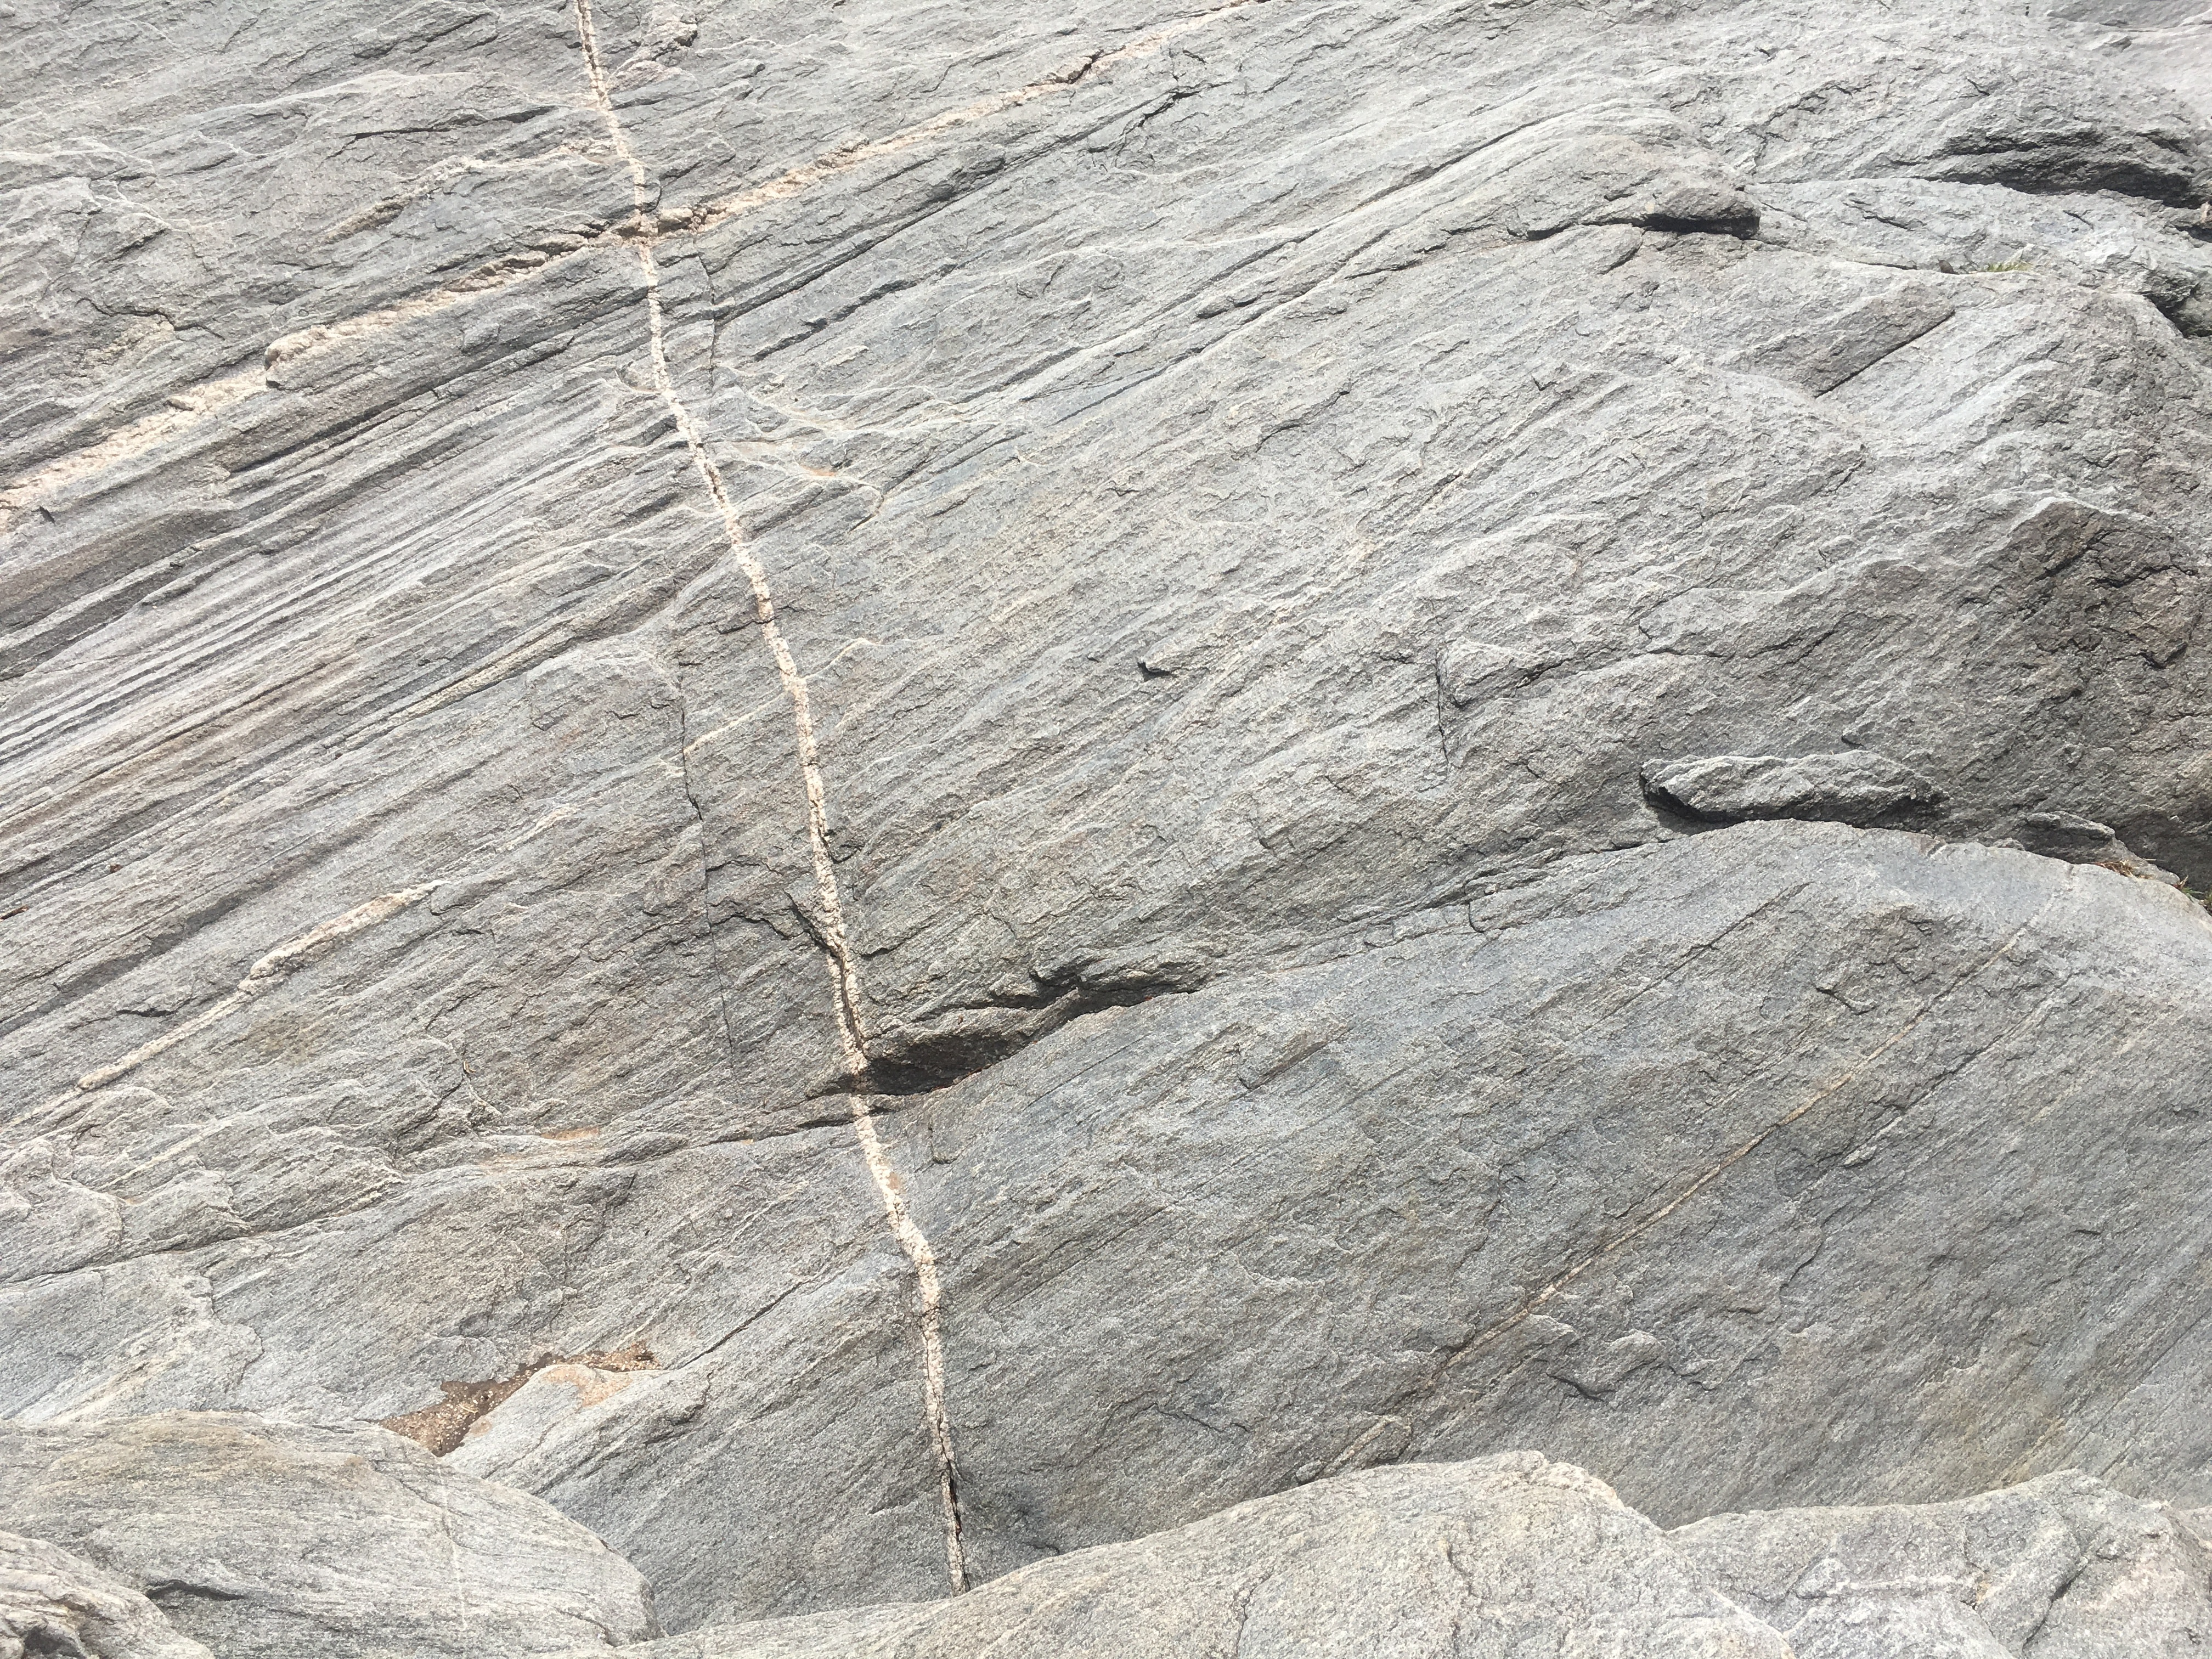
Photo by <a href="https://unsplash.com/@muhozi?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Emery Muhozi</a> on <a href="https://unsplash.com/s/photos/rock?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## How and when to stratify data in machine learning projects to ensure that predictions are accurate and meaningful using just 7 lines of Python code

### Background
I recently worked on a real-world machine learning project which initially produced a set of predictions that were rejected by the domain experts because they could not accept that the future would out-turn in the way the model was predicting.

The causes of the  problem revolved around the changing nature of the aspect of the business represented by the data over time i.e. the future was not going to out-turn like the past. 

This can mean that a machine learning model may not be accurate enough to be meaningful but eventually a solution was found by stratifying the data which prompted me to write this article to share the solution so that it can be used by other data scientists who encounter a similar problem.

### Getting Started
The first thing we need is some data. The real-world data used in the project cannot be shared so I have created a fictitious dataset from scractch using the Faker library. This means that **there are no license restrictions on the data and it may be used or re-used for learning and development purposes**.

If you would like to know more about Faker here is a link to the documentation - https://faker.readthedocs.io/en/master/.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
df_completed_loans = pd.read_excel("Data/CompletedCustomerLoans.xlsx", index_col="CustomerNumber") 
df_live_loans = pd.read_excel("Data/LiveCustomerLoans.xlsx", index_col="CustomerNumber") 

df_completed_loans.head()

CustomerGender CustomerAccessedAdvice  CustomerAgeAtStart  \
CustomerNumber                                                             
29061                       F                      N                  52   
81602                       M                      N                  31   
24053                       F                      N                  36   
91503                       F                      N                  51   
95173                       F                      N                  37   

                         CustomerJobTitle CustomerDepartment  \
CustomerNumber                                                 
29061           Higher Education Lecturer    Human Resources   
81602                     Engineer (Site)            Finance   
24053                     Warden / Ranger    Human Resources   
91503                 Dispensing Optician    Human Resources   
95173           Higher Education Lecturer    Human Resources   

                           EmployerBusinessActivity LoanExpectedEndDate  \
CustomerNumber                                                            
29061                                    Healthcare          2018-03-31   
81602                      Electrical Installations          2021-09-06   
24053           Business, Consulting and Management          2020-11-15   
91503                                    Healthcare          2018-04-30   
95173                        Teaching and Education          2017-12-11   

               LoanApplicationMethod  LoanType LoanStatus  
CustomerNumber                                             
29061                         Online    Bronze     Repaid  
81602                      In Person  Platinum  Defaulted  
24053                         Online  Platinum     Repaid  
91503                         Online    Silver  Defaulted  
95173                         Online    Bronze     Repaid

``CompletedCustomerLoans.xlsx`` represents fictitious loans that have completed in one of two statuses or classifications stored in the ``LoanStatus`` target feature. "Repaid" loans completed successfully and were repaid by the customer and "Defaulted" loans were not repaid and completed unsuccessfully.

``LiveCustomerLoans.xlsx`` has exactly the same format but does not have a ``LoanStatus`` as they are still live and yet to complete, either successfully or unsuccessfully.

### Understanding the Problem
A good use of machine learning wold be to train a model on the completed loans that could predict what the future loan status will be for the live loans.

However, we need two things for a model to work in this way -

- A set of raliable, accurate and consistent historic data
- For the future to broadly turn out in a similar way to the past

The second factor is where we have some problems with this data set. An important factor in this data is the ``LoanType`` which can be Bronze, Silver, Gold or Platinum.

The way in which the makeup of loans is set to change over time can be visualised as follows -

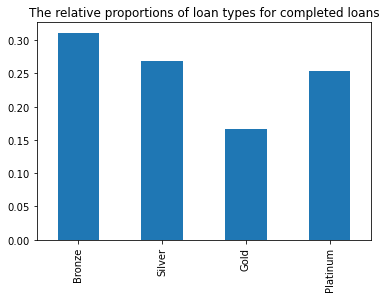

In [3]:
df_completed_loans["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3} )).plot.bar()
plt.title("The relative proportions of loan types for completed loans")
plt.show()

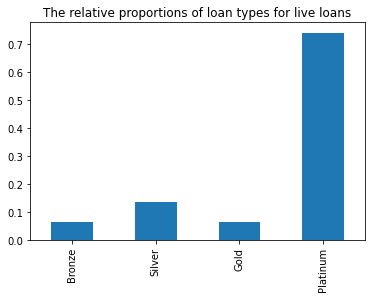

In [4]:
df_live_loans["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3} )).plot.bar()
plt.title("The relative proportions of loan types for live loans")
plt.show()

These charts highlight the problem. Historic / completed loans have a high instance of Bronze, Silver and Gold loans but the live / uncompleted loans do not. It looks like our fictitious loans business is switching all future customers into Platinum loans and discontinuing the other loan types.

If the performance of loans in terms of Repaid vs. Defaulted differs for the different loan types then the machine learning model will produce skewed predictions.

If you have a situation like this you may need to stratify the training data based on the proportions found in the live data to improve the accuracy of the predictions.

The remainder of this article shows how this can be done in less than 5 lines of Python code ...

### Implementing the Solution (The First 5 Lines of Code)
A re-usable function to stratify a dataset based on the proportions of any combination of features found in another dataset can be implemented as follows -

In [5]:
def stratify(sample : pd.DataFrame, population : pd.DataFrame, stratify_cols : list, random_state : int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    weights = (population[stratify_cols].value_counts(normalize=True) * sample.shape[0]).astype(int)

    df_return = sample.groupby(stratify_cols).apply(lambda group: group.sample(n=weights[group.name] if group.name in weights else 0, replace=True, random_state=random_state))
    df_return.index = df_return.index.droplevel(level=stratify_cols)
    
    return df_return, weights

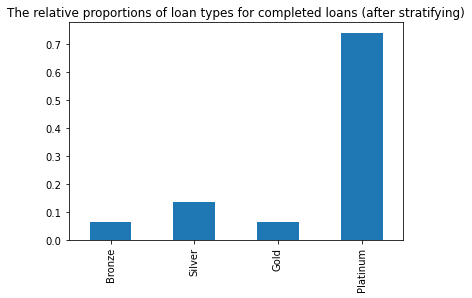

In [6]:
df_completed_loans_stratified, weights = stratify(sample=df_completed_loans, population=df_live_loans, stratify_cols=["LoanType"])

df_completed_loans_stratified["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3} )).plot.bar()
plt.title("The relative proportions of loan types for completed loans (after stratifying)")
plt.show()

In [7]:
df_completed_loans_stratified.head()

CustomerGender CustomerAccessedAdvice  CustomerAgeAtStart  \
CustomerNumber                                                             
32907                       F                      N                  18   
68620                       M                      N                  16   
89482                       M                      N                  21   
67708                       F                      N                  24   
47553                       M                      N                  22   

                        CustomerJobTitle        CustomerDepartment  \
CustomerNumber                                                       
32907             Journalistbroadcasting                   Finance   
68620              Community Arts Worker                Operations   
89482                 Facilities Manager                   Finance   
67708           Horticultural Consultant  Research and Development   
47553                    Mining Engineer  Research and Development   

                     EmployerBusinessActivity LoanExpectedEndDate  \
CustomerNumber                                                      
32907                Electrical Installations          2017-07-31   
68620                            Construction          2018-01-29   
89482           Engineering and Manufacturing          2018-07-31   
67708                             Social Care          2020-08-30   
47553                      Sports and Leisure          2018-05-24   

               LoanApplicationMethod LoanType LoanStatus  
CustomerNumber                                            
32907                      In Person   Bronze     Repaid  
68620                      In Person   Bronze     Repaid  
89482                      In Person   Bronze     Repaid  
67708                         Online   Bronze  Defaulted  
47553                         Online   Bronze  Defaulted

### Understanding the Solution
The ``stratify`` function achieves its purpose in just 3 lines of code which is the Pythonic way but reducing the number of lines of code can decrease the readability so let's pick it apart to understand what is going on ...

In [8]:
sample = df_completed_loans
population = df_live_loans
stratify_cols=["LoanType"]
random_state = 42

This is the first line of code ...

In [9]:
weights = (population[stratify_cols].value_counts(normalize=True) * sample.shape[0]).astype(int)

``stratify_cols`` contains a list of data fileds to use to construct the weights. 

The return type of this line of code is a Pandas Series where index contains the range of values found in the population data and the value contains the percentage of rows found with this value. 

``normalize=True`` tells ``value_counts`` to return percentages instead of actual counts. These values are then multiplied by the total number of records found in the sample data (``sample.shape[0]``) to arrive at the number of records required in the sample dataset to reflect the proportions found in the population.

In [10]:
print(type(weights))
print(weights.index)
weights

<class 'pandas.core.series.Series'>
MultiIndex([('Platinum',),
            (  'Silver',),
            (  'Bronze',),
            (    'Gold',)],
           names=['LoanType'])


LoanType
Platinum    2032
Silver       367
Bronze       170
Gold         170
dtype: int32

Here is the next line of code. It is doing quite a lot which I will explain in stages ...

In [11]:
df_return = sample.groupby(stratify_cols).apply(lambda group: group.sample(n=weights[group.name] if group.name in weights else 0, replace=True, random_state=random_state))

Lets start at the beginning. ``sample.groupby(stratify_cols)`` returns a ``DataFrameGroupBy`` object with a group for each unique combination found in ``stratify_cols``. This can be visualised as follows ...

In [12]:
sample.groupby(stratify_cols).apply(lambda group: print(group.name))

Bronze
Gold
Platinum
Silver


Empty DataFrame
Columns: []
Index: []

``group.sample(n=weights[group.name])`` then uses the group name to index the weights Series and extract the number of records to sample ...

In [13]:
weights["Bronze"]

170

The last part simply acknowledges that there may be values in the sample data not found in the population data so the inline ``if`` statement simply samples zero rows should any data found matching this condition - 

```
group.sample(n=weights[group.name] if group.name in weights else 0
```

The parameter ``replace=True`` in the sample puts each sampled row back into the data so it can be resampled if necessary and ``random_state`` is set to enable reproducible results.

Lastly the magic of lambda functions means that the sample returned for each group is joined together to produce a single DataFrame.

To explain the 3rd and final line of code let's take a quick look at ``df_return`` -

In [14]:
df_return.head()

CustomerGender CustomerAccessedAdvice  \
LoanType CustomerNumber                                         
Bronze   32907                       F                      N   
         68620                       M                      N   
         89482                       M                      N   
         67708                       F                      N   
         47553                       M                      N   

                         CustomerAgeAtStart          CustomerJobTitle  \
LoanType CustomerNumber                                                 
Bronze   32907                           18    Journalistbroadcasting   
         68620                           16     Community Arts Worker   
         89482                           21        Facilities Manager   
         67708                           24  Horticultural Consultant   
         47553                           22           Mining Engineer   

                               CustomerDepartment  \
LoanType CustomerNumber                             
Bronze   32907                            Finance   
         68620                         Operations   
         89482                            Finance   
         67708           Research and Development   
         47553           Research and Development   

                              EmployerBusinessActivity LoanExpectedEndDate  \
LoanType CustomerNumber                                                      
Bronze   32907                Electrical Installations          2017-07-31   
         68620                            Construction          2018-01-29   
         89482           Engineering and Manufacturing          2018-07-31   
         67708                             Social Care          2020-08-30   
         47553                      Sports and Leisure          2018-05-24   

                        LoanApplicationMethod LoanType LoanStatus  
LoanType CustomerNumber                                            
Bronze   32907                      In Person   Bronze     Repaid  
         68620                      In Person   Bronze     Repaid  
         89482                      In Person   Bronze     Repaid  
         67708                         Online   Bronze  Defaulted  
         47553                         Online   Bronze  Defaulted

This does not look quite right. Pandas has returned a ``MultiIndex`` and this needs to be made to look like the simple index that was found in the original data without losing the index values.

This took quite a bit of research and documentation reading but it turns out that the index can be restored to its original format by dropping the mult-part that relates to the features that were used to build the index in the first place -

In [15]:
df_return.index = df_return.index.droplevel(level=stratify_cols)
df_return.head()

CustomerGender CustomerAccessedAdvice  CustomerAgeAtStart  \
CustomerNumber                                                             
32907                       F                      N                  18   
68620                       M                      N                  16   
89482                       M                      N                  21   
67708                       F                      N                  24   
47553                       M                      N                  22   

                        CustomerJobTitle        CustomerDepartment  \
CustomerNumber                                                       
32907             Journalistbroadcasting                   Finance   
68620              Community Arts Worker                Operations   
89482                 Facilities Manager                   Finance   
67708           Horticultural Consultant  Research and Development   
47553                    Mining Engineer  Research and Development   

                     EmployerBusinessActivity LoanExpectedEndDate  \
CustomerNumber                                                      
32907                Electrical Installations          2017-07-31   
68620                            Construction          2018-01-29   
89482           Engineering and Manufacturing          2018-07-31   
67708                             Social Care          2020-08-30   
47553                      Sports and Leisure          2018-05-24   

               LoanApplicationMethod LoanType LoanStatus  
CustomerNumber                                            
32907                      In Person   Bronze     Repaid  
68620                      In Person   Bronze     Repaid  
89482                      In Person   Bronze     Repaid  
67708                         Online   Bronze  Defaulted  
47553                         Online   Bronze  Defaulted

### A Final Improvement (7 Lines of Code in Total)
Now we have a function that can stratify any dataset by the proportions found in another dataset but what if we simply know the desired proportions but we do not have a population dataset?

This can be implemented with just one additional line of code in the ``build_weights`` function and a small change to ``stratify`` to accept the ``weights`` as an optional parameter.

Please note that ``sample_size`` is set to ``0 `` if the list of ``values`` represents the number of rows. If instead ``values`` contains a set of floating point numbers that add up to ``1`` (i.e. percentages) the ``sample_size`` contains the number of records to multiply the percentages by to sample.

The single line of code in ``build_weights`` is fairly self explanatory. It uses inline ``if`` statements to pass the appropriate values for the ``data``, and ``index`` parameters. It did take a fair bit of research to find out how to construct a ``MultiIndex`` for the instance where there is more than one level but the finished code is very clean ...

In [16]:
def build_weights(index : list, level_names : list, values : list, sample_size : int = 0) -> pd.Series:
    return pd.Series(data=values if sample_size == 0 else [int(sample_size * value) for value in values], index=index if len(level_names) == 1 else pd.MultiIndex.from_tuples(index, names=level_names))

def stratify(sample : pd.DataFrame, population : pd.DataFrame, stratify_cols : list, weights : pd.Series = None, random_state : int = 42) -> Tuple[pd.DataFrame, pd.Series]:
    weights = (population[stratify_cols].value_counts(normalize=True) * sample.shape[0]).astype(int)  if weights is None else weights

    df_return = sample.groupby(stratify_cols).apply(lambda group: group.sample(n=weights[group.name] if group.name in weights else 0, replace=True, random_state=random_state))
    df_return.index = df_return.index.droplevel(level=stratify_cols)
    
    return df_return, weights

In [17]:
weights = build_weights(index=["Bronze", "Silver", "Gold", "Platinum"], level_names=["LoanType"], values=[1000, 500, 250, 100])
weights

Bronze      1000
Silver       500
Gold         250
Platinum     100
dtype: int64

or ...

In [18]:
weights = build_weights(index=["Bronze", "Silver", "Gold", "Platinum"], level_names=["LoanType"], values=[0.5, 0.25, 0.125, 0.05], sample_size=2000)
weights

Bronze      1000
Silver       500
Gold         250
Platinum     100
dtype: int64

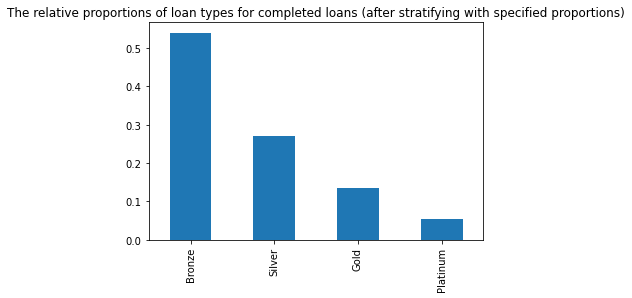

In [19]:
df_completed_loans_stratified, weights = stratify(sample=df_completed_loans, population=df_live_loans, stratify_cols=["LoanType"], weights=weights)

df_completed_loans_stratified["LoanType"].value_counts(normalize=True).sort_index(key=lambda x: x.map({'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3} )).plot.bar()
plt.title("The relative proportions of loan types for completed loans (after stratifying with specified proportions)")
plt.show()

### Conclusion
In this article the case for when stratifying data can significantly improve the performance of a machine learning model. This has been presented by citing a real-world project and then demonstrated using fictitious and synthetic data.

A simple function has been developed in just 3 lines of Python code that can stratify any dataset given the proportions found in another dataset, thereby preparing data for modelling that matches the conditions described.

Finally an additional function has been provided that can build the weights to pass into the function that performs the stratify to meet the case where the data scientist knows what the proportions should be but does not have access to a dataset that contains the right proportions.

### Thank you for reading!
If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/? Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn — https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.

If you would like to support the author and 1000’s of others who contribute to article writing world-wide by subscribing, please use the following link (note: the author will receive a proportion of the fees if you sign up using this link at no extra cost to you).

https://grahamharrison-86487.medium.com/membership